# Crash Prediction: Predicting crash severity level and finding important crash factors

-By Muhammad Awais, Richard Chai, Muhammad Sakha

## What was the motivation/drive behind this project? 

Car accidents happen everywhere around us. On the daily we see headlines along the lines of "Drunk teen drives car off freeway". It's frustrating seeing accidents happen as often as they do, and even more infuriurating when they cause of the accident was something very avoidable such as intoxicated while driving, or not wearing a seatbelt. Alleghany County has more accidents than Eastern Pennsylavania counties of Philadelphia, Delaware and Montgomery each of which have more people per square mile than Allegheny County, which is quite a dubious distinction.

In 2010, according to the crash statistics from Dot.gov, there were 32,999 fatalities in 2,967 car accidents. In 2018, there were over 38,000 fatalities in over 3,400 car accidents. Although the general change in deaths per capita due to accidents have fallen very slightly, the amount of deaths is still a shockingly large number. That’s over 201 deaths per day due to accidents for the past year. How many of these accidents could have been avoided if drivers had been more careful? A good amount

Not too long ago, we had an accident occur right in our own backyard, on Forbes and Morewood, not two blocks away from campus. Unfortunately, there wasn't too much information available concerning the logistics of the accidents, and possible factors that may have caused it.


These situations made us wonder, what kind of factors around driving can we employ to minimize the amount of accidents that happen and injuries that result? Aside from the obvious don'ts like drinking and driving, were there any other underlying factors that create more injuries and fatalities during accidents? With all the turmoil in politics nowadays, we decided to create a way to best predict preventable factors that cause fatalities and injuries in accidents, that are able to be implemented as policies, something all parties can agree on!

## What does it help with?
Ostensibily, this may seem like a task that could be overly simple with the involement of drunk or distracted drivers, but the dataset presented so many characteristics of crashes that one wouldn't even think of to be, such as the size of the car involved, the lighting during the accident, and how many people were in the car. Beyond the obvious ones, many of which are already present in present day policies, we wanted to see if we could dig deeper and find more subtle traits that could be causing a lot of accidents.


# Importing required packages

In [8]:
import ckanapi 
from pprint import pprint
import pandas as pd
import numpy as np
import scipy

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot as skplt
import seaborn as sns
import geopandas as gpd

# Getting data using API

We had a couple of choices of data sources to choose from including Penn DOT, U.S. Government’s open data (DATA.GOV). We decided to use Western Pennsylvania Regional Data Center [WPRDC](http://www.wprdc.org/) data source because it caters exclusively on Western Pennsylvania (Alleghany County). The dataset  also had a few extra parameters with a total of 191 parameters to analyze and choose from than any other sources we examined.

The data is retrieved using an WPRDC API directly, and fed into memory as a pandas dataframe.

The dataset contains a large number of individual accident events, in the year 2017, over 12,538. The dataset contains features regarding weather conditions (rain, snow etc.), road conditions (wet road, snow sleet, dry etc.), vehicle type (SUV, truck, motorcycle etc.), driver related (drinking, speeding, distracted etc.), accident type (rear end, head-on collision etc.), casuality details (deaths/injuries) and damage details (hit bridge/guardrails etc.). 


The features of the data contain characteristics of each event, both pre and post accident. After analysis, we decided to separate the features into two categories; the pre-determined factors and the post-detirministic factors. 
One example of a pre-detirmined feature is whether or not the driver was drunk, and an example of a post-detirmined feature is whether or not there was a fatality as a result of that the accident.
The reason that we needed to split up the features like this was because we didn't want to use factors that are deterministic of our outcome variable of inerest as that would bias our analysis.

In [4]:
site = "https://data.wprdc.org"
def get_resource_data(site,resource_id,count=50):
    # Use the datastore_search API endpoint to get <count> records from
    # a CKAN resource.
    ckan = ckanapi.RemoteCKAN(site)
    response = ckan.action.datastore_search(id=resource_id, limit=count)
    data = response['records']
    return data

In [5]:
crash_data_2017 = get_resource_data(site,resource_id="bf8b3c7e-8d60-40df-9134-21606a451c1a",count=999999999)
df = pd.DataFrame(crash_data_2017)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Exploratory Data Analysis


### Geo Mapping crashes in Allegheny County

We downloaded the shape file for Municipal Boundaries in Pennslyvania state from [Open Data PA](https://data.pa.gov/). We then filtered out Allegheny County from among the other municiapl counties in state. 

Further we converted Allegheny County from ESRI 4222 to ESRI 4326 coordinate format. This was required as our accident dataset contains cordinates in the ESRI 4326. We required the data about municipalities in Allegheny County as this was essentially how our accident dataset was subdivided among various municipalities.

Here you can see a plot of Allegheny County with a total of 130 municipalities, the largest in Pennsylvania state. 

C:\ProgramData\Anaconda 3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


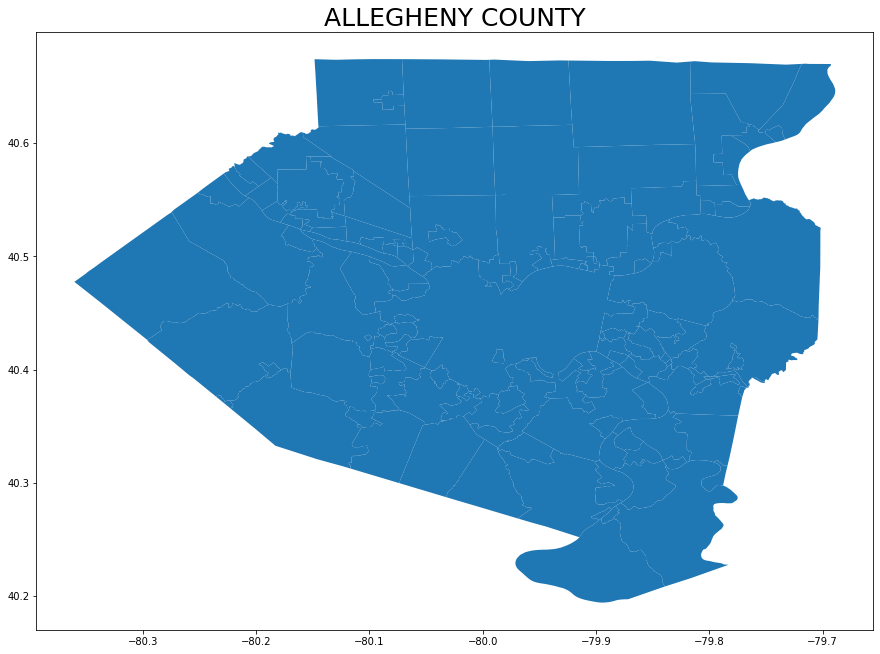

In [25]:
map_old = gpd.read_file(r'MUNICIPAL_BOUNDARY.shp')

map_new = map_old[map_old['COUNTY']== '02']
map_data = map_new.to_crs(epsg=4326)

fig,ax = plt.subplots(figsize = (15,15))
ax.set_title('ALLEGHENY COUNTY', fontdict= 
            {'fontsize':25})
map_data.plot(ax = ax)

We converted out dataset cordinates into a Point format (x,y) using Shapely. Later we converted out dataframe into a geopandas dataframe to plot it as a GIS map. We can see below that most of the accidents are concentrated in 3 major municipalities near the Pittsburgh downtown area (center of the map below) which is not surprising.

Further, we can see that there is a set random pattern to the accidents. Accidents that cause injury/death (outcome) or not appear with the same frequency within similar locations along road network which makes for a difficult prediction task. We initially suspected that we'd find accidents happening for obvious reasons (drinking, slippery roads, fog etc.) but to our surprise most occur in ideal (normal) road and weather conditions as we explain earlier. Apparently, there seem to be an inherently random nature of car accident.

Our outcome of interest is the binary variable ("Injury_or_Fatal"). On this map, red represents an injury or fatality. Visually, it is very hard to draw conclusions based on the specific geographical areas, where weather and road conditions are constant.

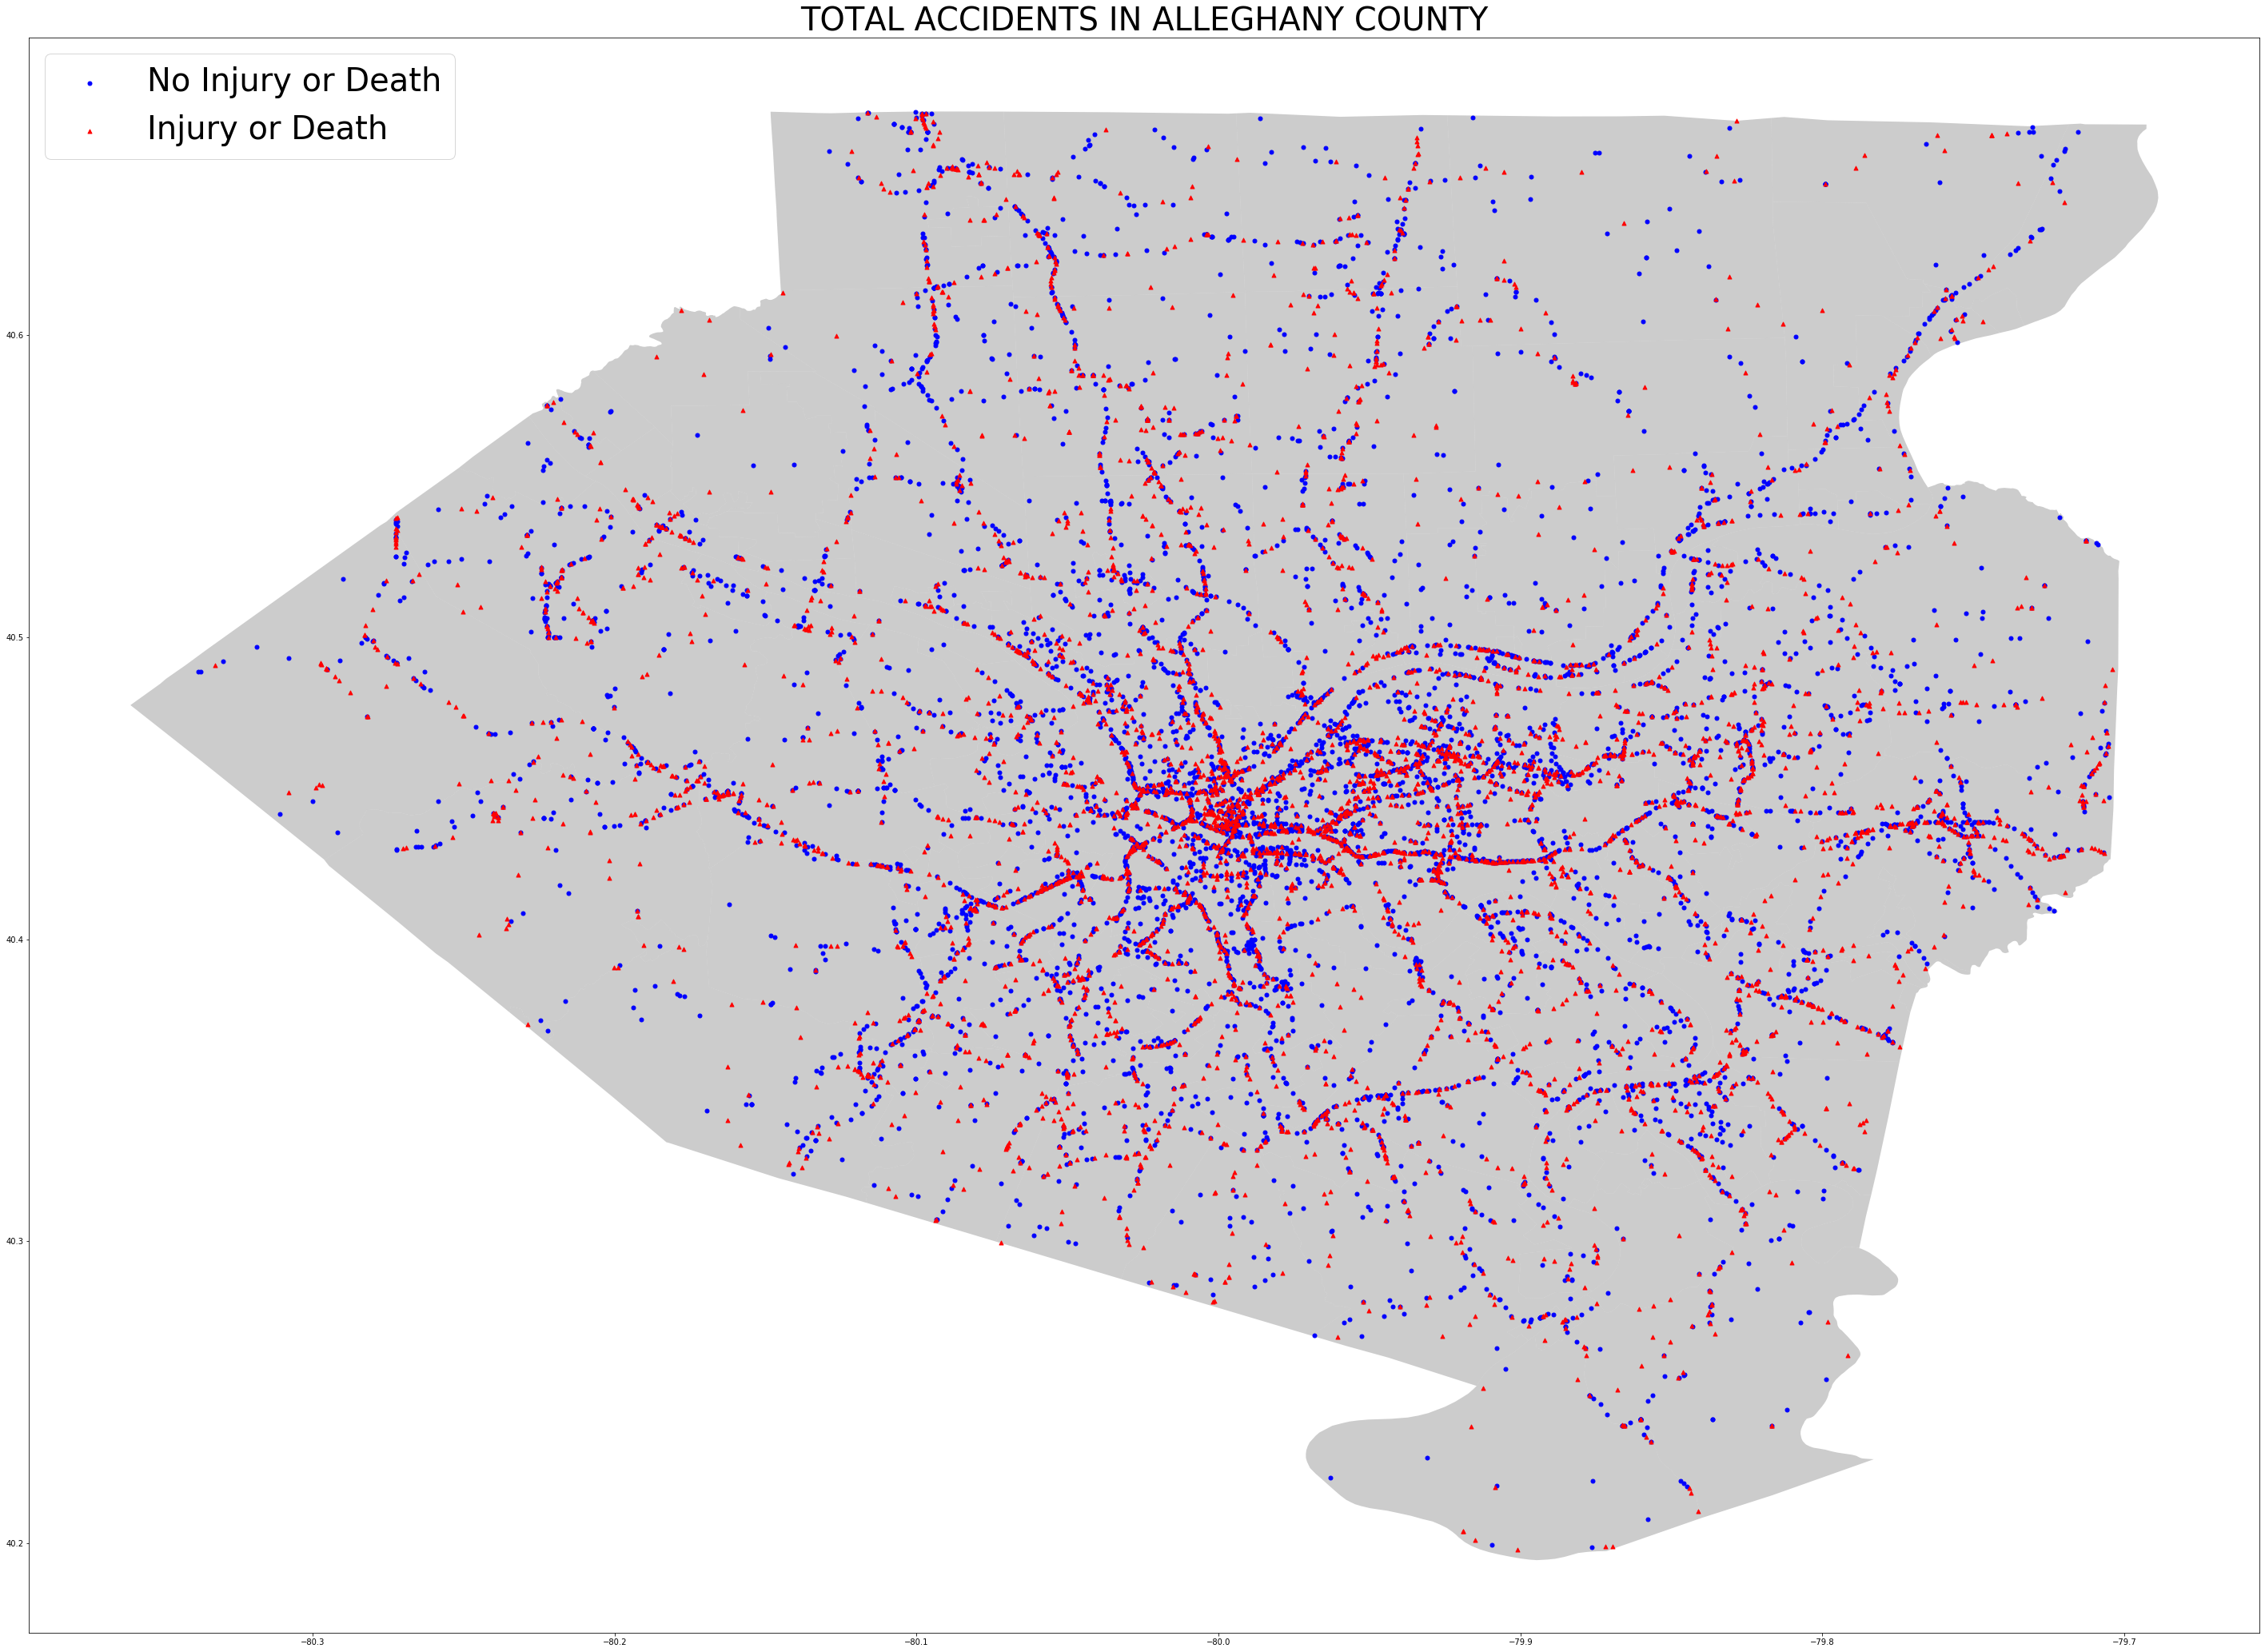

In [9]:
crs = {'init': 'espg:4326'}
geometry = [Point (xy) for xy in zip (df['DEC_LONG'], df['DEC_LAT'])]


geom = []
index = []
for i in range(len(geometry)):
    j=np.zeros(0)
    j= np.array(map_data.contains(geometry[i]))
    if (np.sum(j) != 0):
        geom.append(geometry[i])
    else:
        index.append(i)
        pass

df_ind = df.drop(index)
    
geo_df = gpd.GeoDataFrame(df_ind, crs =crs, geometry=geom)


fig,ax = plt.subplots(figsize = (50,50))
ax.set_title('TOTAL ACCIDENTS IN ALLEGHANY COUNTY', fontdict= 
            {'fontsize':40})
map_data.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['INJURY_OR_FATAL']==0].plot(ax=ax, markersize=25, color='blue', marker = 'o', label = 'No Injury or Death')
geo_df[geo_df['INJURY_OR_FATAL']==1].plot(ax=ax, markersize=25, color='red', marker = '^', label = 'Injury or Death')
plt.legend(prop = {'size':40})

### Choropleth map of crash data
Here we first sum the number of accidents which result in injury/fatality (outcome = 1) by municipalities in Alleghany county. We then merge the accident dataset divided by municipalities with the our municipalities geo dataframe (shape file).

Here you can see that most of the accidents with injury/fatality (outcome = 1) are concentrated in downtown area (center of the map below).

In [11]:
df1 = df.copy()
df1['MUNICIPALITY'] = df1['MUNICIPALITY'].str[1:]
mun_acc = df1.groupby('MUNICIPALITY')['INJURY_OR_FATAL'].sum()

columns = ['COUNTY', 'MUNICIPAL_']
map_data['MUNICIPAL'] = map_data[columns].astype(str).sum(axis=1).astype('int64')
map_data['MUNICIPAL'] = map_data['MUNICIPAL'].astype('str')
for_plotting = map_data.merge(mun_acc, left_on = 'MUNICIPAL', right_on = 'MUNICIPALITY')

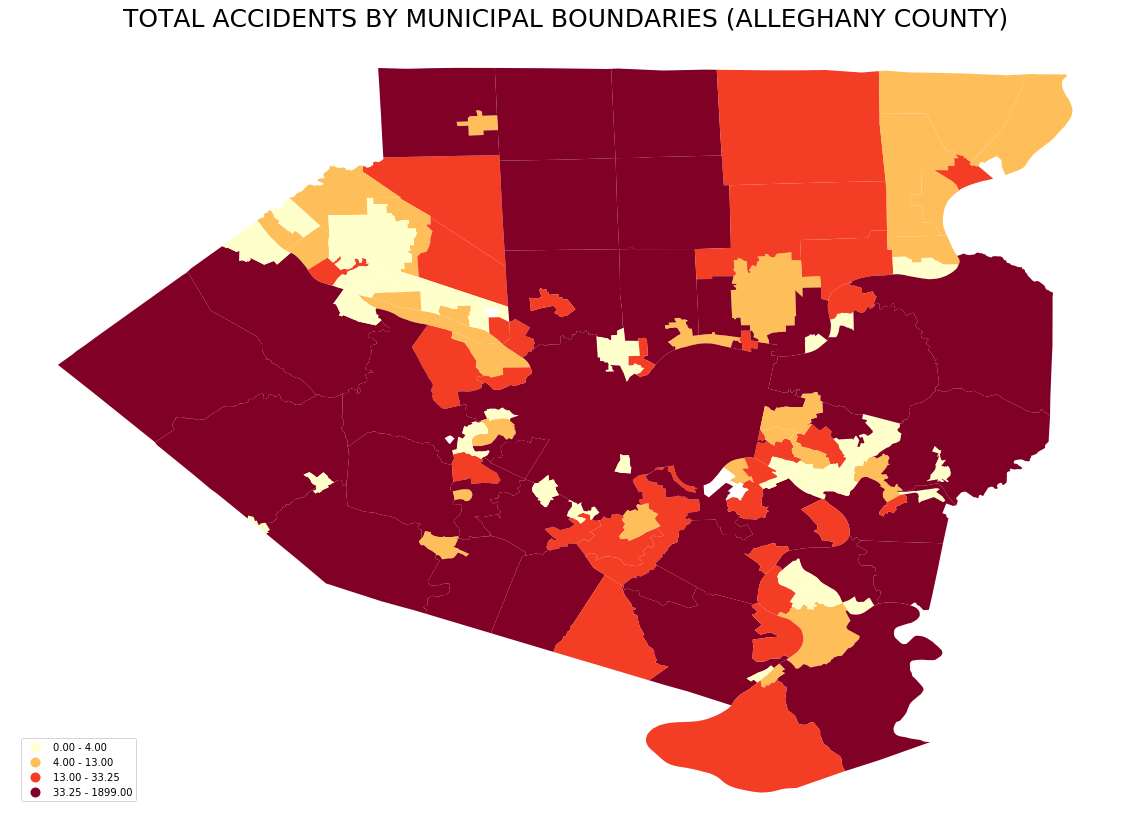

In [12]:
ax = for_plotting.plot(column='INJURY_OR_FATAL', cmap =    
                                'YlOrRd', figsize=(20,20),   
                                 scheme='quantiles', k=4, legend =  
                                  True);

ax.set_title('TOTAL ACCIDENTS BY MUNICIPAL BOUNDARIES (ALLEGHANY COUNTY)', fontdict= 
            {'fontsize':25})
#remove axes
ax.set_axis_off()
#move legend to an empty space
ax.get_legend().set_bbox_to_anchor((.12,.12))

Specially we can see that three municipalities have the most number of accidents with injury/fatality (outcome = 1). Especially 2301 with most accidents is the Pittsburgh downtown area.

In [13]:
mun_ls = df1.MUNICIPALITY.unique().tolist()

# print(type(df4.shape[1]))
# df_count = pd.DataFrame(index=index, columns=['MUNICIPAL', 'INJURY_OR_DEATH'])
# df_count

mun_inj_t = []
mun_ls_t = []
for i in range(len(mun_ls)):
    if (mun_acc[mun_ls[i]]>200):
            mun_inj_t.append(mun_acc[mun_ls[i]])
            mun_ls_t.append(mun_ls[i])
    else:
        pass
    
df_inj_t = pd.DataFrame()
df_inj_t['MUNICIPALITY']  = mun_ls_t
df_inj_t['INJURY_DEATH']  = mun_inj_t

df_inj_t

,MUNICIPALITY,INJURY_DEATH
0,2113,252
1,2301,1899
2,2446,204


### Histograms showing distribution of Driver, Road and Weather related conditions

Here we can see that a majority of accidents occur in normal weather conditions with a slight spike for rain and snow. This adds to the randomness that we have to deal with in our dataset regarding accidents. 

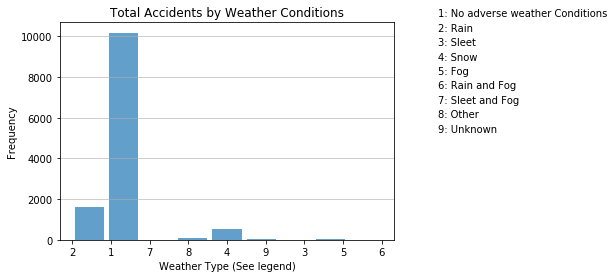

In [15]:
n, bins, patches = plt.hist(x=df['WEATHER'], bins=9, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Weather Type (See legend)')
plt.ylabel('Frequency')
plt.title('Total Accidents by Weather Conditions')
dick = {1:"j"}
plt.figtext(1,0.90,"1: No adverse weather Conditions")
plt.figtext(1,0.85,"2: Rain")
plt.figtext(1,0.80,"3: Sleet")
plt.figtext(1,0.75,"4: Snow")
plt.figtext(1,0.70,"5: Fog")
plt.figtext(1,0.65,"6: Rain and Fog")
plt.figtext(1,0.60,"7: Sleet and Fog")
plt.figtext(1,0.55,"8: Other")
plt.figtext(1,0.50,"9: Unknown")
plt.show()

Here we can see that a majority of accidents occur in normal dry road conditions with a slight spike for wet road conditions. Hence we can see here around <20% of accidents are due to wet road conditions which adds to our earlier analysis about accidents taking place in rainy weather conditions explained above.

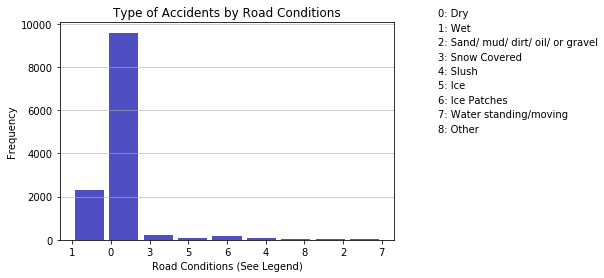

In [16]:
n, bins, patches = plt.hist(x=df['ROAD_CONDITION'], bins=9, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Road Conditions (See Legend)')
plt.ylabel('Frequency')
plt.title('Type of Accidents by Road Conditions')
dick = {1:"j"}
plt.figtext(1,0.90,"0: Dry")
plt.figtext(1,0.85,"1: Wet")
plt.figtext(1,0.80,"2: Sand/ mud/ dirt/ oil/ or gravel")
plt.figtext(1,0.75,"3: Snow Covered")
plt.figtext(1,0.70,"4: Slush")
plt.figtext(1,0.65,"5: Ice")
plt.figtext(1,0.60,"6: Ice Patches")
plt.figtext(1,0.55,"7: Water standing/moving")
plt.figtext(1,0.50,"8: Other")
plt.show()

Here we can see that a majority of accidents occur in days leading up to the weekend around Thursday and Fridays which is reasonaable as traffic spikes occur during these days.

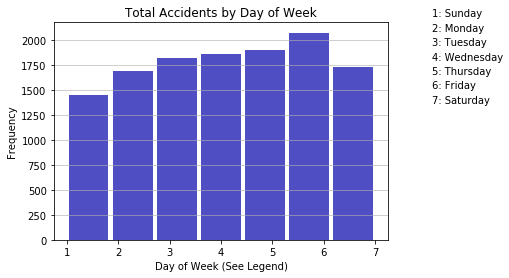

In [17]:
n, bins, patches = plt.hist(x=df['DAY_OF_WEEK'], bins=7, color='#0504aa', alpha=0.7, rwidth=0.90)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Day of Week (See Legend)')
plt.ylabel('Frequency')
plt.title('Total Accidents by Day of Week')
plt.figtext(1,0.90,"1: Sunday")
plt.figtext(1,0.85,"2: Monday")
plt.figtext(1,0.80,"3: Tuesday")
plt.figtext(1,0.75,"4: Wednesday")
plt.figtext(1,0.70,"5: Thursday")
plt.figtext(1,0.65,"6: Friday")
plt.figtext(1,0.60,"7: Saturday")
plt.show()

Here we can see that accidents occur with almost the same frequency in each of the months. However in January, May, June, October and December we see a slight increase. This is as we analyzed earlier are months that are associate with rains and snow in Alleghany region.

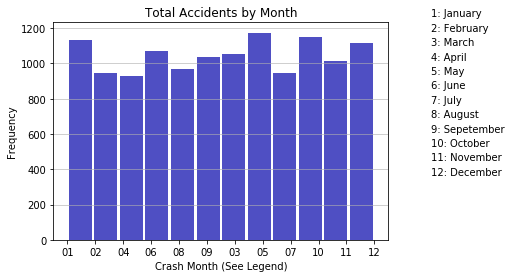

In [19]:
n, bins, patches = plt.hist(x=df['CRASH_MONTH'], bins=12, color='#0504aa', alpha=0.7, rwidth=0.9)

plt.grid(axis='y', alpha= 0.75)
plt.xlabel('Crash Month (See Legend)')
plt.ylabel('Frequency')
plt.title('Total Accidents by Month')
plt.figtext(1,0.90,"1: January")
plt.figtext(1,0.85,"2: February")
plt.figtext(1,0.80,"3: March")
plt.figtext(1,0.75,"4: April")
plt.figtext(1,0.70,"5: May")
plt.figtext(1,0.65,"6: June")
plt.figtext(1,0.60,"7: July")
plt.figtext(1,0.55,"8: August")
plt.figtext(1,0.50,"9: Sepetember")
plt.figtext(1,0.45,"10: October")
plt.figtext(1,0.40,"11: November")
plt.figtext(1,0.35,"12: December")
plt.show()

We can clearly see here that drunk driving does not appear to be prevalent in our sample. However since most of the accidents in our dataset lead to injuries rather than deaths i.e approximately 98%, it might be that the accidents involving drinking may be more deadly compared to sober driving.

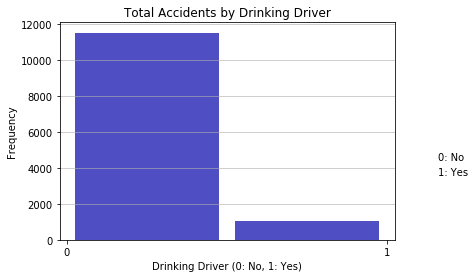

In [26]:
n, bins, patches = plt.hist(x=df['DRINKING_DRIVER'], bins=2, color='#0504aa', alpha=0.7, rwidth=0.9)
plt.grid(axis='y', alpha= 0.75)
plt.xlabel('Drinking Driver (0: No, 1: Yes)')
plt.ylabel('Frequency')
plt.title('Total Accidents by Drinking Driver')
plt.xticks((0,1))
plt.figtext(1,0.40,"0: No")
plt.figtext(1,0.35,"1: Yes")
plt.show()

### Correlation matrix - within features

We analyzed our dataset and saw very high correlation among various features highlighted in red, upto 80 - 100%. This is due to the fact that a lot of features are derived from their related features leading to high correlation such as among DRIVER_18YR and DRIVER_COUNT_18YR which are basically variation of the same feature. We also filtered out certain features that were constant/had very small variance. We also removed deterministic features related to our outcome.

We determined the values to remove through ranking the correlation based on the correlation matrix. These features were removed to avoid multicollinearity among our feature dataset.


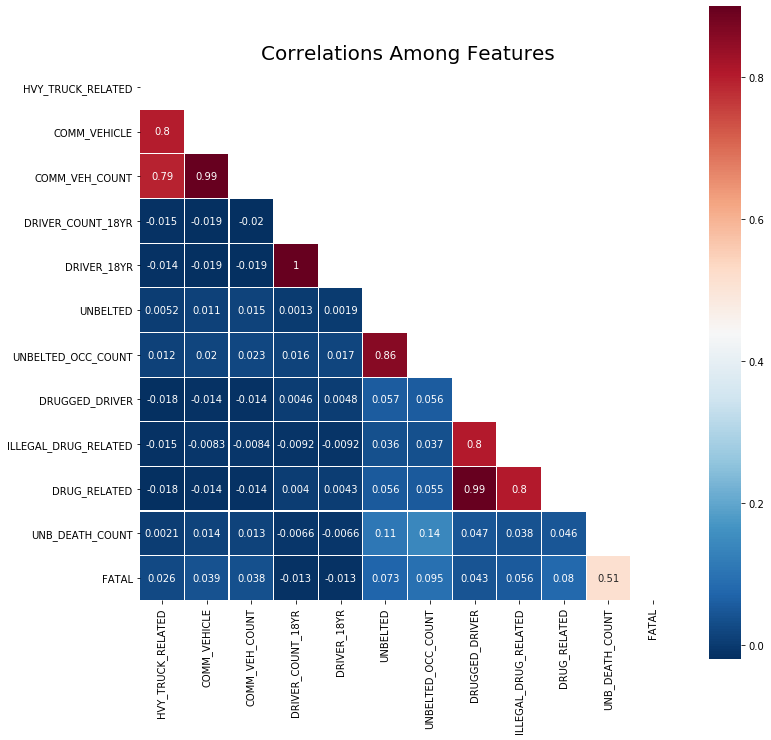

In [14]:
df_corr = df.filter(['HVY_TRUCK_RELATED', 'COMM_VEHICLE', 'COMM_VEH_COUNT', 'DRIVER_COUNT_18YR', 'DRIVER_18YR','UNBELTED', 'UNBELTED_OCC_COUNT','DRUGGED_DRIVER', 'ILLEGAL_DRUG_RELATED', 'DRUG_RELATED', 'UNB_DEATH_COUNT', 'FATAL' ], axis=1)
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (12,12))
sns.heatmap(df_corr.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20)
plt.show()

# Data pre-processing

As described earlier, we removed features because of the following reasons:

1. Constant values/extremely small variance/Significanty large number of null values


2. Multi-colllinearity


3. We deleted columns pertaining to post-crash deterministic variables


In [21]:
variables="_id MODERATE_INJURY AUTOMOBILE_COUNT BICYCLE_COUNT BUS_COUNT PROPERTY_DAMAGE_ONLY COMM_VEH_COUNT CURVE_DVR_ERROR DEER_RELATED DRIVER_COUNT_16YR DRIVER_COUNT_17YR DRIVER_COUNT_18YR DRIVER_COUNT_19YR SPEEDING_RELATED STATE_ROAD SUDDEN_DEER SUV_COUNT SV_RUN_OFF_RD STOP_CONTROLLED_INT TIME_OF_DAY TOTAL_UNITS VAN_COUNT WORK_ZONE_IND RDWY_ORIENT OFFSET SEGMENT ROUTE STREET_NAME SCH_ZONE_IND SCH_BUS_IND NTFY_HIWY_MAINT DEC_LONG DEC_LAT LN_CLOSE_DIR EST_HRS_CLOSED TFC_DETOUR_IND ADJ_RDWY_SEQ WZ_SHLDER_MDN WZ_OTHER WZ_MOVING WZ_LN_CLOSURE WZ_LAW_OFFCR_IND WZ_FLAGGER WZ_CLOSE_DETOUR WORKERS_PRES CONS_ZONE_SPD_LIM WORK_ZONE_LOC WORK_ZONE_TYPE SPEC_JURIS_CD RDWY_SURF_TYPE_CD TOT_INJ_COUNT ACCESS_CTRL ROADWAY_COUNTY ROADWAY_CRN PSP_REPORTED MINOR_INJURY MAJOR_INJURY FIRE_IN_VEHICLE VEHICLE_TOWED OVERTURNED HIT_DEER HIT_TREE_SHRUB HIT_EMBANKMENT HIT_POLE HIT_GDRAIL HIT_GDRAIL_END HIT_BARRIER HIT_BRIDGE FATAL_OR_MAJ_INJ INJURY FATAL LATITUDE LONGITUDE MAX_SEVERITY_LEVEL PED_DEATH_COUNT PED_MAJ_INJ_COUNT BELTED_MAJ_INJ_COUNT MCYCLE_DEATH_COUNT MCYCLE_MAJ_INJ_COUNT BICYCLE_DEATH_COUNT BICYCLE_MAJ_INJ_COUNT UNK_INJ_PER_COUNT UNBELTED_OCC_COUNT UNB_DEATH_COUNT UNB_MAJ_INJ_COUNT BELTED_DEATH_COUNT FATAL_COUNT INJURY_COUNT MAJ_INJ_COUNT MOD_INJ_COUNT MIN_INJ_COUNT UNK_INJ_DEG_COUNT FLAG_CRN CRASH_CRN MUNICIPALITY DISTRICT CRASH_COUNTY POLICE_AGCY CRASH_YEAR"
variables_arr=variables.split(' ')

clean_df =df.drop(variables_arr,axis=1)
clean_df = clean_df.dropna(axis = 0)
clean_df = clean_df.apply(pd.to_numeric)



Let's take a look at the data

In [22]:
clean_df.describe()

,AGGRESSIVE_DRIVING,ALCOHOL_RELATED,BICYCLE,CELL_PHONE,COLLISION_TYPE,COMM_VEHICLE,CRASH_MONTH,CROSS_MEDIAN,CURVED_ROAD,DAY_OF_WEEK,DISTRACTED,DRINKING_DRIVER,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_50_64YR,DRIVER_65_74YR,DRIVER_75PLUS,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,DRUGGED_DRIVER,DRUG_RELATED,FATIGUE_ASLEEP,HAZARDOUS_TRUCK,HEAVY_TRUCK_COUNT,HIT_FIXED_OBJECT,HIT_PARKED_VEHICLE,HOUR_OF_DAY,HO_OPPDIR_SDSWP,HVY_TRUCK_RELATED,ICY_ROAD,ILLEGAL_DRUG_RELATED,ILLUMINATION,ILLUMINATION_DARK,IMPAIRED_DRIVER,INJURY_OR_FATAL,INTERSECTION,INTERSECT_TYPE,INTERSTATE,LANE_CLOSED,LANE_COUNT,LIMIT_65MPH,LOCAL_ROAD,LOCAL_ROAD_ONLY,LOCATION_TYPE,MC_DRINKING_DRIVER,MOTORCYCLE,MOTORCYCLE_COUNT,NHTSA_AGG_DRIVING,NON_INTERSECTION,NO_CLEARANCE,PEDESTRIAN,PED_COUNT,PERSON_COUNT,PHANTOM_VEHICLE,RDWY_SEQ_NUM,REAR_END,RELATION_TO_ROAD,ROAD_CONDITION,ROAD_OWNER,RUNNING_RED_LT,RUNNING_STOP_SIGN,SCHOOL_BUS,SCHOOL_BUS_UNIT,SCHOOL_ZONE,SHLDR_RELATED,SIGNALIZED_INT,SMALL_TRUCK_COUNT,SNOW_SLUSH_ROAD,SPEEDING,SPEED_LIMIT,TAILGATING,TCD_FUNC_CD,TCD_TYPE,TRAIN,TRAIN_TROLLEY,TROLLEY,TURNPIKE,UNBELTED,UNDERAGE_DRNK_DRV,UNLICENSED,UNSIGNALIZED_INT,URBAN_RURAL,VEHICLE_COUNT,VEHICLE_FAILURE,WEATHER,WET_ROAD,WORK_ZONE
count,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.00000,12536.00000,12536.0,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000,12536.000000
mean,0.500399,0.085354,0.006382,0.010929,4.031429,0.049298,6.534780,0.016672,0.177250,4.134253,0.140954,0.082403,0.011168,0.031509,0.034700,0.035578,0.040763,0.300654,0.107770,0.062301,0.041321,0.340619,0.112157,0.064135,0.009094,0.009333,0.013960,0.000399,0.037173,0.242900,0.086391,13.361758,0.076819,0.034541,0.019943,0.006063,1.750080,0.332722,0.089502,0.429084,0.434269,0.892629,0.096442,0.701819,2.969608,0.018906,0.588545,0.391512,0.749840,0.001675,0.021219,0.022176,0.040683,0.565731,0.062939,0.032706,0.035019,2.392629,0.006621,3.509413,0.281509,1.883615,0.415683,3.009732,0.031031,0.018108,0.007817,0.001994,0.002872,0.000638,0.170868,0.182195,0.024330,0.040204,32.645980,0.061902,1.052170,0.895501,0.00016,0.00016,0.0,0.011168,0.091417,0.003031,0.002553,0.263401,2.957881,1.873325,0.054244,1.348915,0.183791,0.019065
std,0.500020,0.279419,0.079633,0.103971,2.545691,0.216498,3.484982,0.128044,0.381895,1.941856,0.347988,0.274988,0.105090,0.174696,0.183026,0.185242,0.197748,0.458561,0.310102,0.241710,0.201826,0.556469,0.329183,0.252382,0.094931,0.096160,0.117329,0.019968,0.193776,0.428853,0.280952,9.052012,0.266314,0.182620,0.139809,0.077629,1.105161,0.471207,0.285479,0.494965,0.495680,1.506097,0.295209,0.772348,8.812850,0.136197,0.492117,0.488108,5.810047,0.040896,0.144119,0.151006,0.197562,0.495680,0.242862,0.177873,0.197638,1.802172,0.081103,0.719376,0.449753,1.568009,1.093071,1.163355,0.173407,0.133347,0.088074,0.044614,0.053514,0.025255,0.376409,0.419305,0.154078,0.196446,12.455851,0.240987,1.502767,1.397790,0

### Normalizing data

We normalized the data using the following formula to be used for our Support Vector Machine and Logistic Regression. 

In [23]:
# Normalizing data for SVM and Logistic
clean_normalized = clean_df
normalized_column = "TOTAL_UNITS PERSON_COUNT VEHICLE_COUNT AUTOMOBILE_COUNT MOTORCYCLE_COUNT MOTORCYCLE_COUNT BUS_COUNT SMALL_TRUCK_COUNT HEAVY_TRUCK_COUNT SUV_COUNT VAN_COUNT BICYCLE_COUNT PED_COUNT COMM_VEH_COUNT DRIVER_COUNT_16YR DRIVER_COUNT_17YR DRIVER_COUNT_18YR DRIVER_COUNT_19YR DRIVER_COUNT_20YR DRIVER_COUNT_50_64YR DRIVER_COUNT_65_74YR DRIVER_COUNT_75PLUS LANE_COUNT SPEED_LIMIT"

# Get column names first
normalized_column_list = normalized_column.split(" ")
for col in normalized_column_list:
    if col in clean_normalized.columns:
        clean_normalized[col].update((clean_normalized[col]-clean_normalized[col].min())/(clean_normalized[col].max()-clean_normalized[col].min()))

### Train_test split

In [131]:
# Separating features and label into different dataframes
def get_train_test(df):
    X = df.drop(['INJURY_OR_FATAL'], axis = 1)
    y = df['INJURY_OR_FATAL']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state=42, shuffle = True)
    return X_train, X_test, y_train, y_test


# Function to generate performance metrics

In [132]:
def get_performance(model, X_test, y_test, name = "SVM"):    
    y_predict = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    print('Accuracy Score : ' + str(accuracy_score(y_test, y_predict)))
    print('Precision Score : ' + str(precision_score(y_test, y_predict)))
    print('Recall Score : ' + str(recall_score(y_test, y_predict)))
    print('F1 Score : ' + str(f1_score(y_test, y_predict)))
    
    print("\nROC plot for fine-tuned " +name+ " model is displayed below:")
    #GET ROC DATA
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    #GRAPH DATA
    plt.figure()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(name+' Classifier ROC')
    plt.plot(fpr, tpr, color='blue', lw=2, label= name+ ' ROC area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

Getting train_test split before running model

In [136]:
X_train_normalized,X_test_normalized,y_train_normalized,y_test_normalized = get_train_test(clean_normalized)
X_train_normalized = scipy.sparse.csr_matrix(X_train_normalized.values)
y_train_normalized = np.array(y_train_normalized)

# Support Vector Machine (SVM)
 
Support Vector Machine (SVM) is a supervised Machine Learning Algorithm used to perform classification analysis. An SVM model is a representation of the examples as points in space, divided by hyperplane that has margin separating each category. This margin can be explained as a gap separating points falling in each category from the hyperplane. 

We performed grid search on hyper-parameters in order to tune SVM for the best parameters. We tuned our SVM model for the following hyper-parameters:

1. Kernel: We tuned this parameter to select between linear or rbf kernel (to handle non-linear classification). 


2. C: This is penalty parameter that means how much samples inside the margin contribute to the error. Larger value of C means small margin and vice versa. With small value of C, samples inside the margin are penalized less than with the higher value of C. Higher C would lead to the loss of generalization of the SVM model. 


3. Gamma: This parameter is only relevant for the rbf kernel. This can be thought of as spread of the kernel boundary and hence decision region. A low gamma means the curve of the decision boundary is very low and hence decision region is broad. When gamma is high, the decision boundary is high and it creates islands of decision region. Small gamma give low bias and high variance, and vice versa.  



In [52]:
param_grid = [{'kernel': ['linear'], 'C': [0.1, 1, 10]}, 
              {'kernel': ['rbf'],'C': [0.1, 1, 10],
               'gamma': [0.001, 0.01,1]}] 

 
grid_set_svm = GridSearchCV(svm.SVC(probability = True), param_grid, scoring = 'roc_auc', cv = 10) 
  
# fitting the model for grid search 
grid_svm = grid_set_svm.fit(X_train_normalized, y_train_normalized) 
print('Best Score: ', grid_svm.best_score_)
print('Best Params: ', grid_svm.best_params_)

Best Score:  0.6730373309507914
Best Params:  {'C': 10, 'kernel': 'linear'}


Accuracy Score : 0.6480545954090224
Precision Score : 0.6580359650817531
Recall Score : 0.6109183238291214
F1 Score : 0.5990090515186297

ROC plot for fine-tuned SVM model is displayed below:


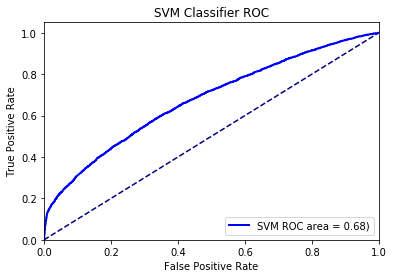

In [53]:
get_performance(grid_svm, X_test_normalized, y_test_normalized, "SVM")

# Logistic Regression

We used logistic regression to predict a categorical variable (1/0) based on a set of independent variable(s). In this Logistic Regression model, the log of odds of the dependent variable is modeled as a linear combination of the independent variables.

Here we first define our model as Logistic regression with some parameters such as type of solver method and the maximum number of iterations (max_iter) that the model should run. We increased the number of iterations (100 - default) to 10000 to be on the safe side but at the cost of time. 



### **GRID SEARCH**

Later we perform a grid search to get the best set of paramemters for our model as initially we weren't getting much in term of model performance. Here we try to get the best set of parameters for the following set of parameters.

1. Penalty 
(‘l1’, ‘l2’, ‘elasticnet’ or ‘none’), Optional: Yes, default=’l2’

   It is used to specify the norm used in the penalization. We'll be just providing l1 and l2 regularization parmeters to our grid search.


2. C 
(float value), Optional: Yes, default=1.0

    Inverse of regularization strength; must be a positive float. Here smaller values specify stronger regularization.


3. class_weight (dict or ‘balanced’),  Optional: Yes , default=None

    Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.The “balanced” mode adjust weights inversely proportional to class frequencies in the input data (y).


4. Solver(‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’), Optional: Yes, default=’lbfgs’

    Algorithm to use in the optimization problem. Here we are using either liblinear and saga. For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

In [78]:
log = LogisticRegression(solver = 'liblinear', max_iter = 10000)#.fit(X_train,y_train)
# y_pred = log.predict(X_test)

In [80]:
penalty = ['l1', 'l2']
C = [0.01, 0.1, 1]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid_set_log = GridSearchCV(estimator=log,
                    param_grid=param_grid,
                    scoring='roc_auc',cv = 10)
grid_log = grid_set_log.fit(X_train_normalized, y_train_normalized)

print('Best Score: ', grid_log.best_score_)
print('Best Params: ', grid_log.best_params_)

Best Score:  0.6511994830338895
Best Params:  {'C': 0.1, 'class_weight': {1: 0.5, 0: 0.5}, 'penalty': 'l2', 'solver': 'liblinear'}


Accuracy Score : 0.6455729859080032
Precision Score : 0.6470225931945226
Recall Score : 0.612690690633702
F1 Score : 0.6052030903392009

ROC plot for fine-tuned Logistic Regression model is displayed below:


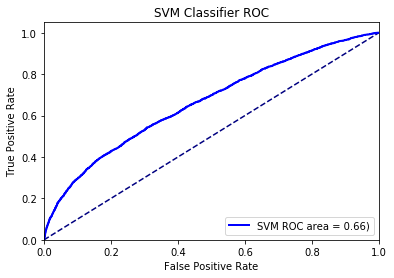

In [81]:
get_performance(grid_log, X_test_normalized, y_test_normalized, "Logistic Regression")

Getting data for Random Forest since it does not require normalized data

In [138]:
X_train,X_test,y_train,y_test = get_train_test(clean_df)
X_train = scipy.sparse.csr_matrix(X_train.values)
y_train = np.array(y_train)

# Random Forest

A Random forest is a group of Decision Trees that make a prediction, and the group of trees, whose size is specified when fitting the data, then creates a consensus prediction based on the outputs of each of the trees. The fundamental concept behind the random forest which makes it so powerful is that a group of predictors can outperform a singular predictor.

The trees are fitted to a random portion of the training data, which averages out the results in the end, and vastly reduces the risk of overfitting. Given that our data has some features that are sometimes clustered, (for example, multiple data points for drugged driver, which is a different from drunk driver), overfitting does pose a risk.

Before runnig the gird search on Random Forest, we first needed to narrow down the parameters to feed into our grid search. In order to do that, we first ran random search on a set parameters. We performed this step for the following parameters:

1. n_estimators: The number of predictors produced by the model. You can think of it as parliament of voters trying to reach the consensus. 

2. max_features: This specifies the number of features at each cut.

3. Bootstrap: Whether the whole trainin dataset is used for training or bootstrap sample. If True, it uses bootstrap sample. 

4. max_depth: the maximum depth of the tree

In [90]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 35, 60, 85, 110, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [50, 87, 125, 162, 200]}


In [91]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 10, random_state=42)
# Fit the random search model
search = rf_random.fit(X_train, y_train)
print('Random Search parameters: ', search.best_params_)

Random Search parameters:  {'n_estimators': 125, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}


Now that we have performed random search, we can skip some of the parameters that have been narrowed down. This will save us a big time in running Random Forest on subset of our initial hyper-parameters.   

In [115]:
n_estimators = [50 , 100, 150]
max_depth = [10, 50, 100]

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

grid_set_rf = GridSearchCV(estimator = RandomForestClassifier(max_features = 'auto',bootstrap = 'False' ), 
                           param_grid = param_grid, cv = 10)

grid_rf = grid_set_rf.fit(X_train, y_train)
print('Best Score: ', grid_rf.best_score_)
print('Best Params: ', grid_rf.best_params_)

Best Score:  0.6664006384676776
Best Params:  {'max_depth': 10, 'n_estimators': 150}


Accuracy Score : 0.6515111229282992
Precision Score : 0.7005699254712845
Recall Score : 0.3296884670930472
F1 Score : 0.4483726150392817

ROC plot for fine-tuned Random Forest model is displayed below:


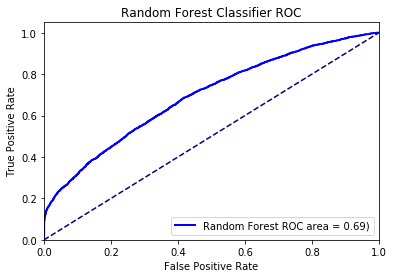

In [123]:
get_performance(grid_rf, X_test, y_test, name = "Random Forest")

# Results

Testing through the 3 models, we detirmined that generally, Random Forest does the best for predicting the outcome of an accident, given the final input features we were given. That had an accuracy of 65 percent. Additionally, precision and auc for Random Forest were marginally better. However, all other models (SVM and Logistic Regression) were very close to Random Forest. Having said that, we belive our model performance were not very impressive and this can be explained due to the following reasons:

1. We determined, unfortunately, that there is an innate random nature of car accidents which make them very hard to predict. Although there are many factors that are in control of the driver, there are also so many factors which we may not have control over and that may affect the outcome, some of which include the road conditions, weather, lighting conditions on the road and time of day.

2. We can conclude that crashes in the most busy municipalities (e.g. Pittsburgh downtown) are random in nature, which makes it very hard to predict the outcome. But most of the injuries/fatalities happen in the high density and busy areas. Results are less random in the outskirts (areas with low population density), but they are still hard to predict. 

3. Some of the important featurs for our prediction task were: 

    A) BICYCLE - Accidents involving a bicyclist have a very high probabaility for injury or death (outcome).
    
    B) PEDESTRIAN - Accidents involving a pedestrian have a very high probabaility for injury or death (outcome).
    
    C) RUNNING_RED_LT - Running a red light is associated with a very high probabaility for injury or death (outcome).
    
    D) UNSIGNALIZED_INT - Intersection with no signals are more likely to result in accidents involving death or injury. This is also explained by our earlier variable RUNNING_RED_LT (running red light) which result in more severe accidents.
    
    E) COLLISION_TYPE - Collision type was important in predicting our outcome. This is especially true for head on collissions especially in case of running a red light as we explained earlier.
    
    F) DRIVER_COUNT_65_74YR - Here we can see that older drivers are more likely to be involved in accidents resudlting in injury and death. There has been movement in some countries for retesting senior drivers to minimize thier risk.
    

# Debugging 


Given that our results were all in the range of mid 60% accuracy for all the models we used. Given this, we tried some of the debugging steps to enhance our model performance. This include:


1. Changing the target variable for instance we changed our target variable to major injury (1/0), moderate injury (1/0). But we still didnt see any significant improvement in our model performances.

2. We changed and tried different combination of features based on the correlation.

Trying these debugging steps were not helpful. This could be explaiend by looking at the following correlation matrix thats shows highest correlation of any feature with the target. We can see that the highest correlation for any feature was 20%.

### Correlation matrix - features against outcome (INJURY_OR_FATAL)
Here we can see that among our finalized features to be used in the model these features offer the highest correlation with our outcome. However we can see that this corelation is very low which adds to randomness associated with our dataset. The maximum corelation that we observe b/w our features and outcome is 20% for Pedestrian which is undestandable as accident involving a pedestrian is likely to result in a injury/death (outcome = 1). Another one is unbelted which is self-explanatory since seat belts are essential safety features.

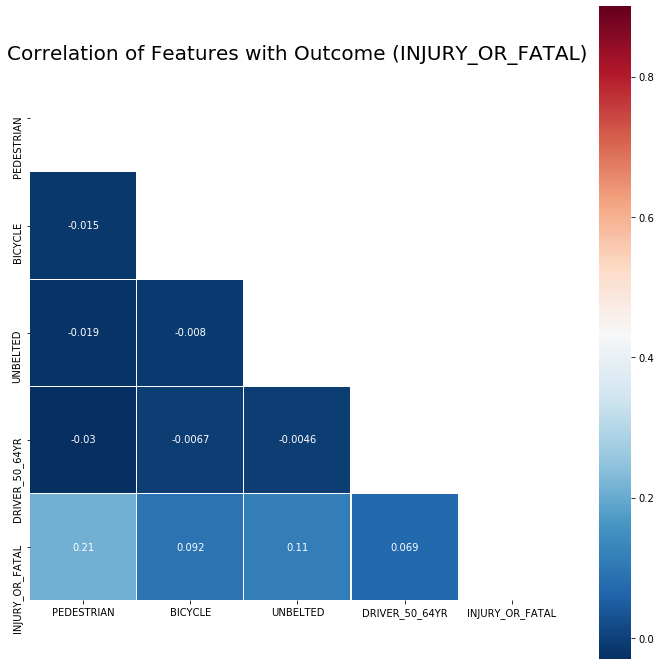

In [27]:
df_corr = df.filter(['PEDESTRIAN', 'BICYCLE', 'UNBELTED', 'DRIVER_50_64YR', 'INJURY_OR_FATAL'], axis=1)
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (12,12))
sns.heatmap(df_corr.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlation of Features with Outcome (INJURY_OR_FATAL)", y = 1.03,fontsize = 20)
plt.show()

# Potential Next Steps

After performing debugging, it was clear that we had inherent randomness in the data, which is also something we can draw from our Exploratory Data Analysis section. Based on this finding, we would like to propose following steps:

1. Use more features by merging data from other sources that might explain crashes for insance we can use images data paired with neural network to enhance the predictive power of the model.

2. It would also be a good idea to gauge the level of uncertainty and try to explain the level of randomness of the crashes.

# Resourses

[Penn DOT NHTSA](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812451)

[Random Forest](https://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics)

[Western Pennsylvania Regional Data Center ](http://www.wprdc.org/)